# References and resources 

* Model trained by : https://www.kaggle.com/adityasreedhar

* DCGAN Paper:  https://arxiv.org/pdf/1511.06434v2.pdf

# Imports 

In [1]:
!pip install gdown -q
import tensorflow as tf  

import gc 
import os 
import numpy as np 
import matplotlib.pyplot as plt

# Helper functions

In [42]:
def plot_image_grid(image_list,
                    label_list = None,
                    sample_images=False,
                    num_images=5,
                    pre_title='class',
                    num_img_per_row=5,
                    cmap=None,
                    img_h_w=5,
                    show=True,
                    save_name = None # path to save image]
                    ):
  
    '''viz images from a list of images and labels
    INPUTS:
    image_list: a list of images to be plotted,
    label_list: a list of correspomding image labels'''
    #number of img rows
    n_row= num_images//num_img_per_row

    fig,ax = plt.subplots(n_row,
               num_img_per_row,
               figsize=(img_h_w*num_img_per_row,(img_h_w-2) *n_row))

#     fig.subplots_adjust(wspace=0, hspace=0)

    if sample_images:
    #select_random images 
        img_ids = random.choices(np.arange(0,len(image_list)),
                             k=num_images)
    else:
        img_ids = range(len(image_list))

    for i,idx in enumerate(img_ids):
        

        img = image_list[idx]
        plt.subplot(n_row,num_img_per_row,i+1)
        if label_list is not None:
            label = label_list[i]
            plt.title(f'{pre_title} {label}')

        plt.axis('off')
        plt.imshow(img,cmap=cmap)
        # break the loop if max limit reached
        if i==num_images-1 :
            
            break 



    if save_name is not None:
        plt.savefig(save_name,bbox_inches='tight', pad_inches=0)

    if show:
    #show
    # plt.tight_layout()
        plt.show()



def de_norm_images(image):

    '''denormalize the image'''
    return (image * 0.5) + 0.5



def get_input_noise(generator_noise_mean,generator_noise_std,num_images =5):
    '''get noise for input to the generator'''
    noise = np.random.normal(loc = generator_noise_mean,
                             scale =generator_noise_std,
                             size= (5,128)
                             )
    
    
    return noise 
  

**Downloading Model**

    The model is a generator model that takes in gaussian noise of dimension 128 as input.

# Loading model

    Loading the pretrained model

In [4]:
generator = tf.keras.models.load_model('./generator_model.h5')

generator.summary()

2022-07-12 08:10:37.709228: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             2113536   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       2

**weights and biases of the first dense layer**

shape of weight matrix (128, 16384)


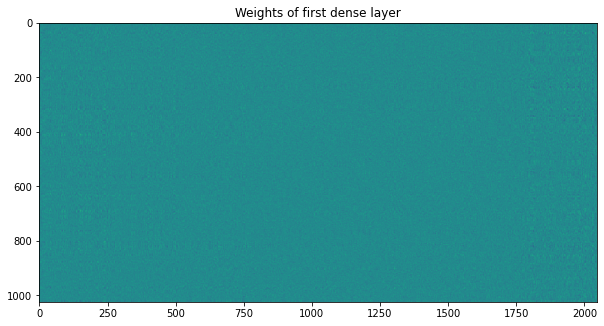

In [19]:

fig = plt.figure(figsize=(10,6))
W = generator.layers[0].get_weights()[0] #weights 
b = generator.layers[0].get_weights()[1]  # biases 

print(f'shape of weight matrix {W.shape}')
plt.imshow(W.reshape((128*8,-1)))
plt.title('Weights of first dense layer')
plt.show()

shape of bias matrix (16384,)


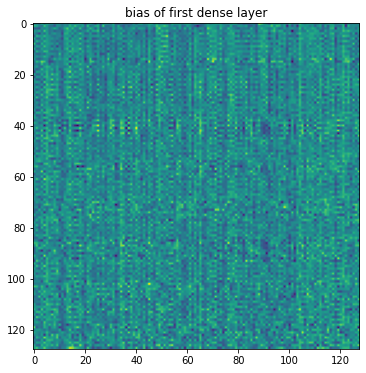

In [14]:

plt.figure(figsize=(10,6))

b = generator.layers[0].get_weights()[1]  # biases 

print(f'shape of bias matrix {b.shape}')
plt.imshow(b.reshape((128,-1)))
plt.title('bias of first dense layer')
plt.show()

# Experiments with the generator

**Passsing in a vector of zeros**

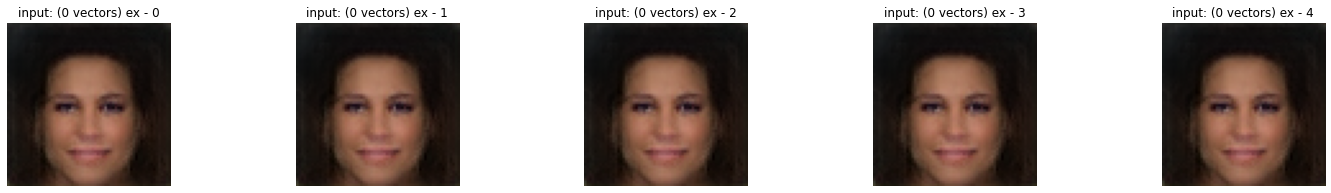

In [44]:
input_noise = np.zeros((5,128))
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
                label_list = np.arange(5),
                sample_images=False,
                num_images=5,
                pre_title='input: (0 vectors) ex -')

**passing in a vector by sampling from normal distribution**

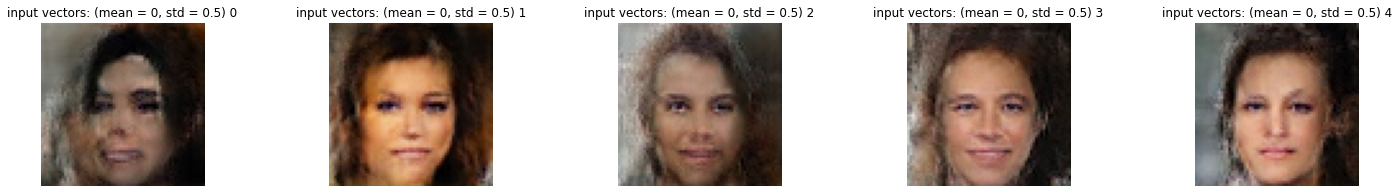

In [45]:
input_noise =get_input_noise(0,0.5) 
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
                label_list = np.arange(5),
                sample_images=False,
                num_images=5,
                pre_title='input vectors: (mean = 0, std = 0.5)')

**what if we feed in the negative value of the vectors that we used to generate the above images?**

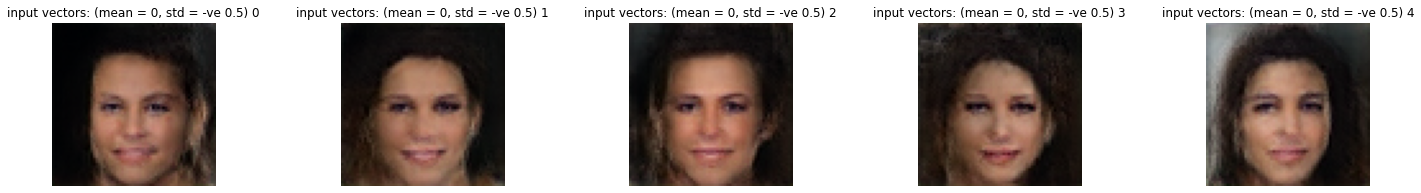

In [50]:
# lets do the onverse images of the above images by taking a negative of the iput vector 

generated_images = generator(-1 * input_noise)


plot_image_grid(image_list=generated_images,
                label_list = np.arange(5),
                sample_images=False,
                num_images=5,
                pre_title='input vectors: (mean = 0, std = -ve 0.5)')

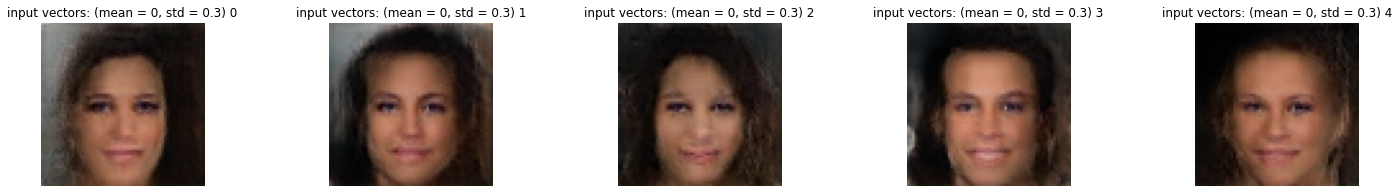

In [48]:
input_noise =get_input_noise(0,0.3) 
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
                label_list = np.arange(5),
                sample_images=False,
                num_images=5,
                pre_title='input vectors: (mean = 0, std = 0.3)')

**inverse of above**

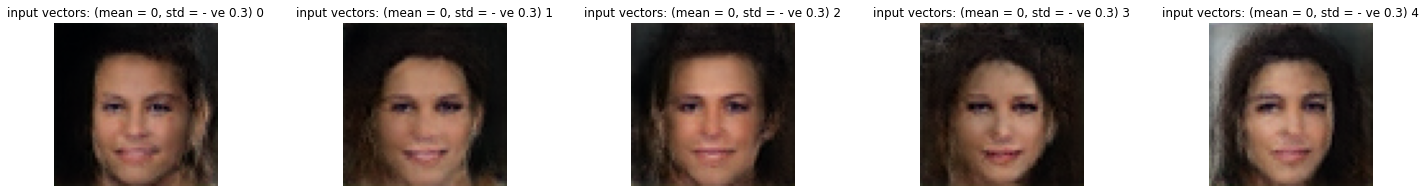

In [51]:

generated_images = generator(input_noise*-1)

plot_image_grid(image_list=generated_images,
                label_list = np.arange(5),
                sample_images=False,
                num_images=5,
                pre_title='input vectors: (mean = 0, std = - ve 0.3)')

# WALKING IN THE LATENT SPACE

    As described in the DCGAN paper, we can make small changes to certain sections of the input noise and observe its effect on the generated image , i,e  walk along that space and see what changes it makes to the generated images. This can help us understand which position in the input noise is contributing to generating some feature in the generated image. Lets explore that in next section.




In [52]:

def generate_walk(index_range:[list,tuple], 
                  increments = [0.3,0.6,0.8,1,1.2],
                 negative_walk = False):
    '''helper to generate input noise with specific values along specified index range.'''
    
    inp_noise = np.zeros((len(increments),128))
    
    mul = 1
    
    #walk in reverse direction
    if negative_walk:
        mul *= -1 
        
    
    for i,_ in enumerate(inp_noise):
        inp_noise[i,index_range[0]:index_range[1]] = mul* increments[i]
        
    return inp_noise

In [99]:
increments = [0.1,0.3,0.5,0.8,1.1,1.3]


**Lets generate images by filling values for index range in range 0:16**

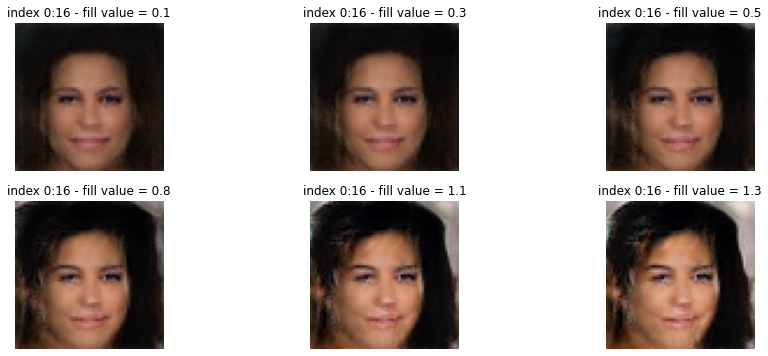

In [116]:
input_noise =  generate_walk(index_range= [0,16],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
                label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 0:16 - fill value =')

**Lets fill the 0:16 with negative values of increments**

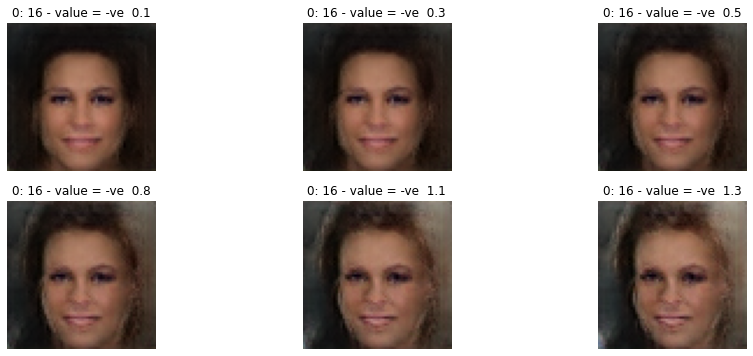

In [117]:
input_noise =  generate_walk(index_range= [0,16],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='0: 16 - value = -ve ')

**generating images by filling values for index range in range 16:32 (1st image grid: positive increments ,2nd image grid: negative increments)**

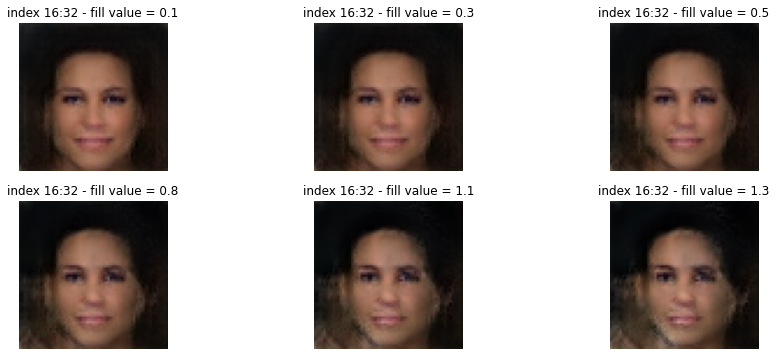

In [118]:
input_noise =  generate_walk(index_range= [16,32],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 16:32 - fill value =')

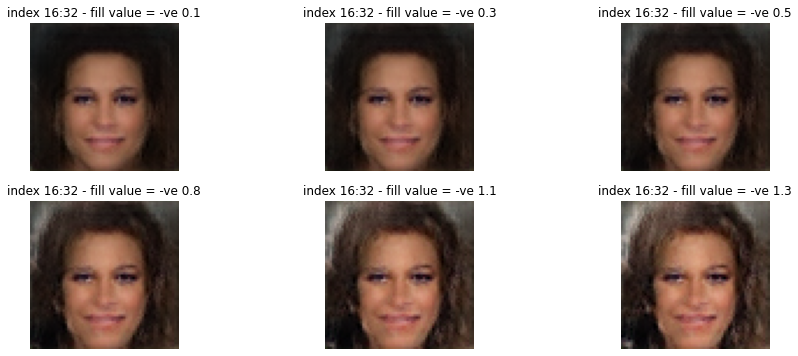

In [119]:
input_noise =  generate_walk(index_range= [16,32],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 16:32 - fill value = -ve')

****generating images by filling values for index range in range 32:48 (1st image grid: positive increments ,2nd image grid: negative increments)****

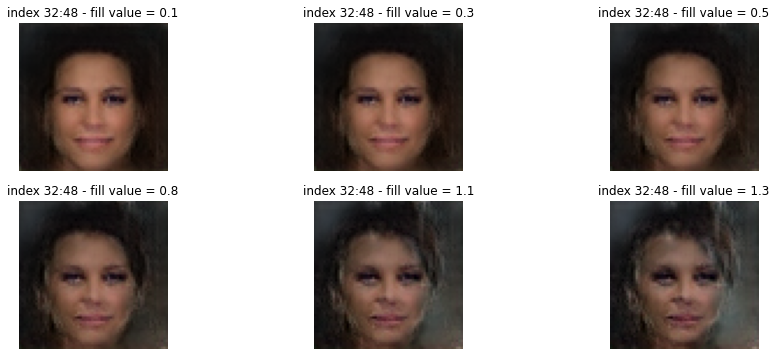

In [120]:
input_noise =  generate_walk(index_range= [32,48],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 32:48 - fill value =')

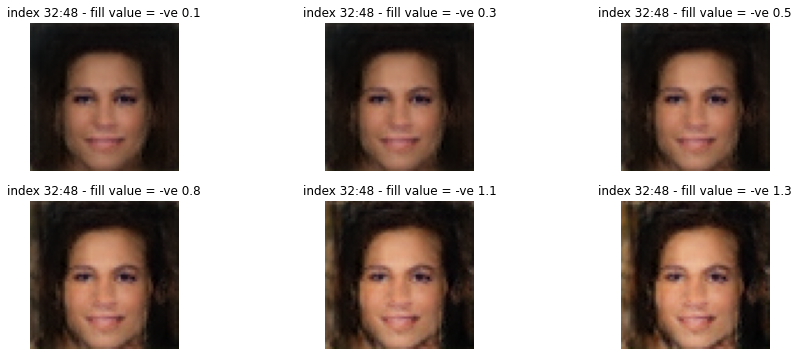

In [121]:
input_noise =  generate_walk(index_range= [32,48],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 32:48 - fill value = -ve')

**generating images by filling values for index range in range 48:64 (1st image grid: positive increments ,2nd image grid: negative increments)**

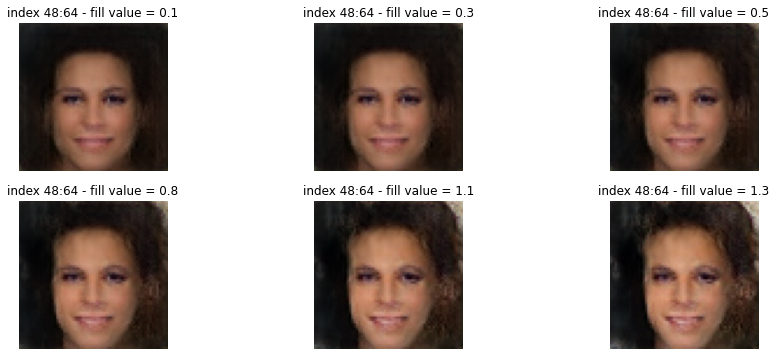

In [122]:
input_noise =  generate_walk(index_range= [48,64],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 48:64 - fill value =')

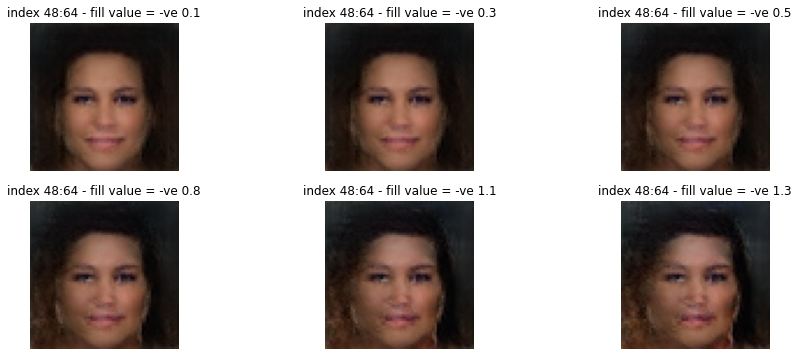

In [123]:
input_noise =  generate_walk(index_range= [48,64],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 48:64 - fill value = -ve')

**generating images by filling values for index range in range 64:80 (1st image grid: positive increments ,2nd image grid: negative increments)**

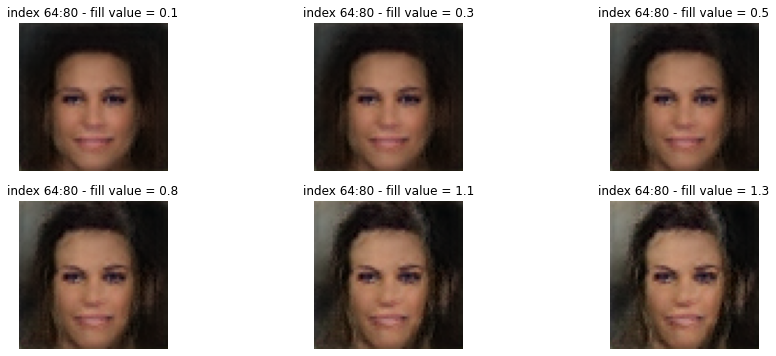

In [124]:
input_noise =  generate_walk(index_range= [64,80],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 64:80 - fill value =')

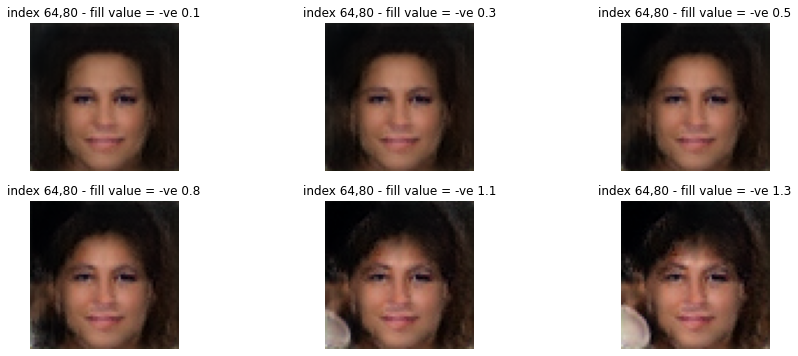

In [125]:
input_noise =  generate_walk(index_range= [64,80],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 64,80 - fill value = -ve')

**generating images by filling values for index range in range 80:96 (1st image grid: positive increments ,2nd image grid: negative increments)**

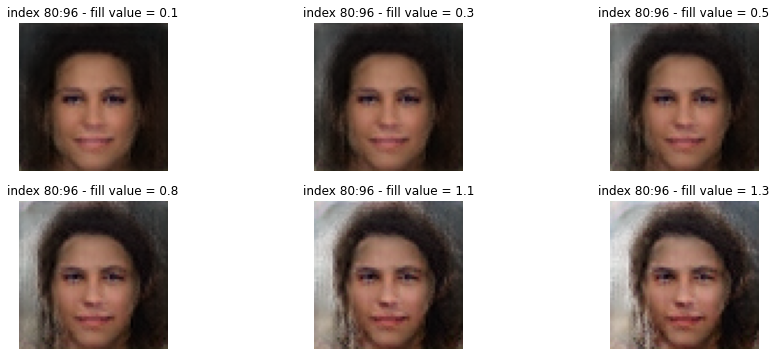

In [126]:
input_noise =  generate_walk(index_range= [80,96],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 80:96 - fill value =')

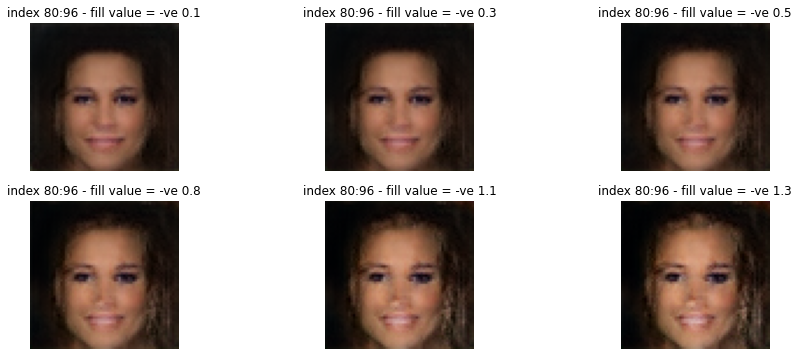

In [127]:
input_noise =  generate_walk(index_range= [80,96],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 80:96 - fill value = -ve')

**generating images by filling values for index range in range 96:112 (1st image grid: positive increments ,2nd image grid: negative increments)**

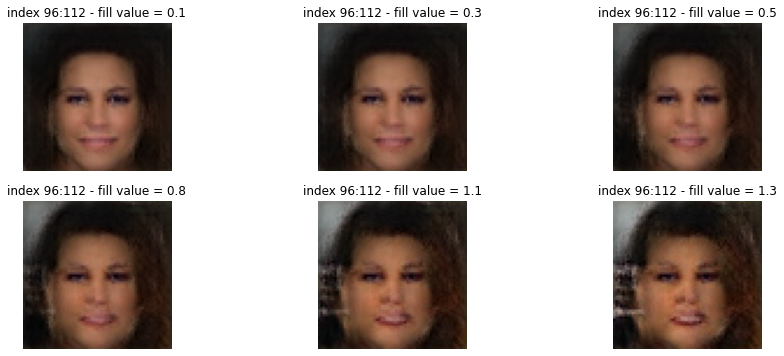

In [128]:
input_noise =  generate_walk(index_range= [96,112],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 96:112 - fill value =')

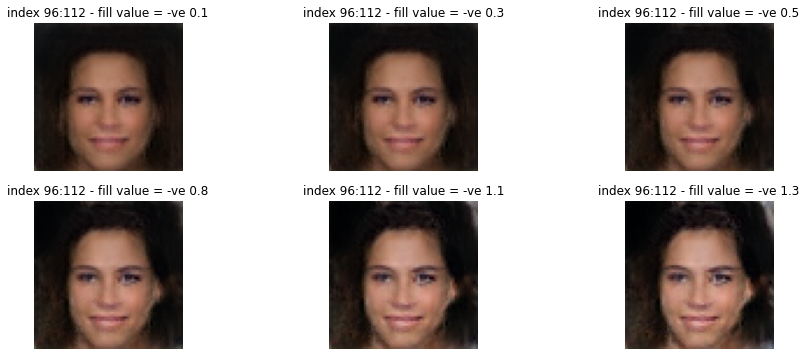

In [129]:
input_noise =  generate_walk(index_range= [96,112],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 96:112 - fill value = -ve')

**generating images by filling values for index range in range 112:128 (1st image grid: positive increments ,2nd image grid: negative increments)**

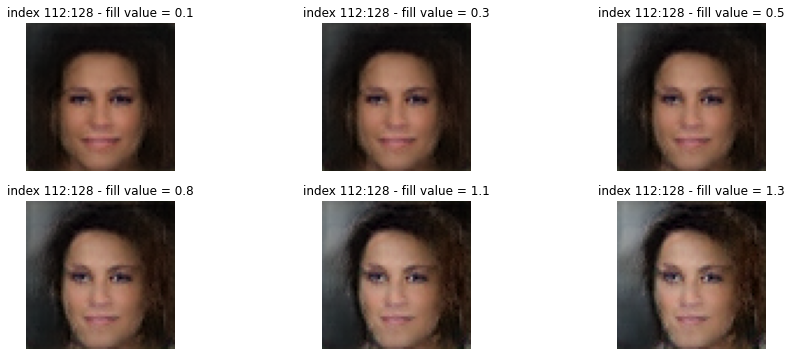

In [130]:
input_noise =  generate_walk(index_range= [112,128],increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 112:128 - fill value =')

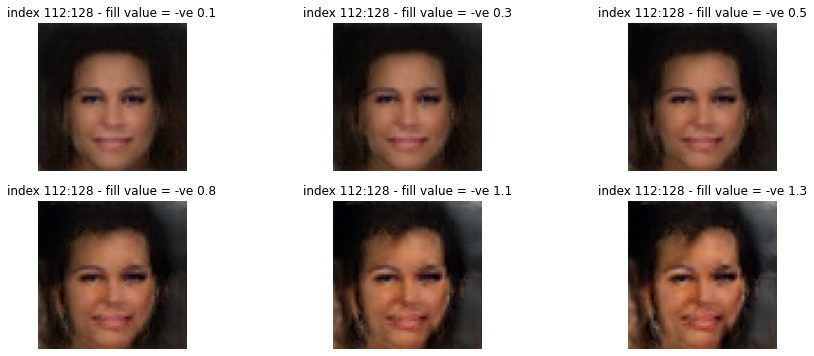

In [131]:
input_noise =  generate_walk(index_range= [112,128],negative_walk=True,increments = increments)
generated_images = generator(input_noise)

plot_image_grid(image_list=generated_images,
               label_list = increments,
                sample_images=False,
                num_img_per_row=len(increments)//2,
                num_images=len(increments),
                pre_title='index 112:128 - fill value = -ve')

**We can try to use these images to build a face design, by creating a input vector using these images as a guide.Lets try to do one example**

# Generate a custom image

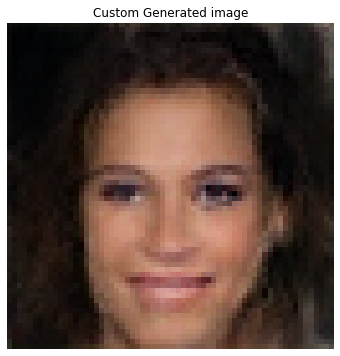

In [136]:
inp_noise = np.zeros((128,))
inp_noise[16:32] = -0.5
inp_noise[80:96] = -0.3 
inp_noise[96:112] = -0.8


generated_im = generator(np.expand_dims(inp_noise,axis=0))[0]

plt.figure(figsize=(10,6))


plt.imshow(generated_im)
plt.title('Custom Generated image')
plt.axis('off')
plt.show()